# Install MQTT Library

With Conda (if you are using Anaconda)

In [1]:
import sys
!conda install -y -p {sys.prefix} -c conda-forge paho-mqtt

'conda' is not recognized as an internal or external command,
operable program or batch file.


With Pip

In [2]:
!pip install paho-mqtt

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Verify that we have the library properly installed

The following code block should not generate an error

In [3]:
import paho.mqtt.client as mqtt

# Parameters

In [4]:
# Replace with your matric ID
YOUR_MATRIC_ID = 'A0262453H' #include the id to add in to the system
# Note that the sensors publish a reading every few seconds
NUM_SAMPLES = 5000

# The following does not need to be changed
MQTT_HOST = '10.246.112.87'
MQTT_SUBPATH = 'ee4211/'
MQTT_LIGHT_SENSOR = 'light_sensor_0/brightness_lux'
MQTT_TEMP_SENSOR = 'temp_sensor_0/temperature_degC'

# Data Collection

Define callback function used to collect published data

In [5]:
import json

def parse_json(msg):
    err = False
    try:
        json_object = json.loads(msg)
    except:
        err = True
    else:
        if 'v' not in json_object or 'ts' not in json_object:
            err = True
    if err:
        print('Malformed reading received:', end=' ')
        print(msg)
        return None
    return json_object

light_readings = []
def collect_received_light(c, u, msg):
    msg = parse_json(msg.payload)
    if not msg: return

    # Two columns, 'timestamp' and 'brightness_lux'
    reading = {}
    # The timestamp is contained in msg['ts']
    reading['timestamp'] = msg['ts']
    # The reading is contained in msg['v']
    reading['brightness_lux'] = msg['v']
    # Cast the reading into an integer
    reading['brightness_lux'] = int(reading['brightness_lux'])
    print('Got light reading:', end=' ')
    print(reading)
    # Append it to the 'light_readings' list
    light_readings.append(reading)

temp_readings = []
def collect_received_temp(c, u, msg):
    msg = parse_json(msg.payload)
    if not msg: return

    # Two columns, 'timestamp' and 'temperature_degC'
    reading = {}
    # The timestamp is contained in msg['ts']
    reading['timestamp'] = msg['ts']
    # The reading is contained in msg['v']
    reading['temperature_degC'] = msg['v']
    # Cast the reading into a float
    reading['temperature_degC'] = float(reading['temperature_degC'])
    print('Got temp reading:', end=' ')
    print(reading)
    # Append it to the 'temp_readings' list
    temp_readings.append(reading)

def collect_received(c, u, msg):
    if MQTT_LIGHT_SENSOR in msg.topic:
        collect_received_light(c, u, msg)
    elif MQTT_TEMP_SENSOR in msg.topic:
        collect_received_temp(c, u, msg)
        



Generate anonymised ID for connection to MQTT server

In [6]:
import hashlib
MQTT_ID = YOUR_MATRIC_ID.lower().strip()
MQTT_ID = hashlib.sha256(MQTT_ID.encode()).hexdigest()[-16:]

Connect to MQTT server

In [7]:
import paho.mqtt.client as mqtt
client = mqtt.Client()
# Attach the on_message callback to the collect_received() function
client.on_message = collect_received
client.username_pw_set(username = MQTT_ID, password = MQTT_ID)
client.connect(MQTT_HOST)
client.loop_start()

C:\Users\power\AppData\Local\Temp\ipykernel_26676\3379750475.py:2: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

Subscribe to sensor topics

In [8]:
# Clear the list of readings first
light_readings = []
temp_readings = []

MQTT_TOPIC = MQTT_SUBPATH + MQTT_ID + '/' + MQTT_LIGHT_SENSOR
client.subscribe(MQTT_TOPIC)
print('Subscribed to topic:', end=' ')
print(MQTT_TOPIC)

MQTT_TOPIC = MQTT_SUBPATH + MQTT_ID + '/' + MQTT_TEMP_SENSOR
client.subscribe(MQTT_TOPIC)
print('Subscribed to topic:', end=' ')
print(MQTT_TOPIC)

Subscribed to topic: ee4211/674ce880e46a68c1/light_sensor_0/brightness_lux
Subscribed to topic: ee4211/674ce880e46a68c1/temp_sensor_0/temperature_degC


Wait for the required number of readings to accumulate and disconnect.

If you do not see any readings being collected within a few seconds, something is wrong. Check that you have your matric id filled in correctly.

In [9]:
from time import sleep
while len(light_readings) < NUM_SAMPLES or len(temp_readings) < NUM_SAMPLES:
    sleep(1.0)
client.disconnect()
client.loop_stop()

print('Number of light readings obtained:', end=' ')
print(len(light_readings))

print('Number of temp readings obtained:', end=' ')
print(len(temp_readings))

Got light reading: {'timestamp': '2022-11-01 15:31:00.474389', 'brightness_lux': 7435}
Got temp reading: {'timestamp': '2022-11-01 15:31:00.474389', 'temperature_degC': 30.407}
Got light reading: {'timestamp': '2022-11-01 15:32:00.820179', 'brightness_lux': 5339}
Got temp reading: {'timestamp': '2022-11-01 15:32:00.820179', 'temperature_degC': 30.419}
Got light reading: {'timestamp': '2022-11-01 15:33:00.573108', 'brightness_lux': 7370}
Got temp reading: {'timestamp': '2022-11-01 15:33:00.573108', 'temperature_degC': 30.437}
Got light reading: {'timestamp': '2022-11-01 15:34:01.676481', 'brightness_lux': 11902}
Got temp reading: {'timestamp': '2022-11-01 15:34:01.676481', 'temperature_degC': 30.434}
Got light reading: {'timestamp': '2022-11-01 15:35:01.572804', 'brightness_lux': 11050}
Got temp reading: {'timestamp': '2022-11-01 15:35:01.572804', 'temperature_degC': 30.451}
Got light reading: {'timestamp': '2022-11-01 15:36:01.875393', 'brightness_lux': 6874}
Got temp reading: {'timest

KeyboardInterrupt: 

Dump the readings to a JSON file for offline processing

In [10]:
import json
import time
curr_time = int(time.time())
with open(f'readings_{curr_time}_light.json', 'w') as f:
    json.dump(light_readings, f)
with open(f'readings_{curr_time}_temp.json', 'w') as f:
    json.dump(temp_readings, f)

# Data Processing

Write your data processing functions to answer the questions in the worksheet.

Your normal data visualisation and processing libraries such as seaborn, pandas and numpy are available.

Timestamp: 2022-09-16 08:46:00.573168 Brightness (lux): 15358
Timestamp: 2022-09-16 08:47:01.135377 Brightness (lux): 8790
Timestamp: 2022-09-16 08:47:01.135377 Brightness (lux): 8790
Timestamp: 2022-09-16 08:48:00.182031 Brightness (lux): 16096
Timestamp: 2022-09-16 08:48:00.182031 Brightness (lux): 16096
Timestamp: 2022-09-16 08:49:01.864820 Brightness (lux): 8657
Timestamp: 2022-09-16 08:49:01.864820 Brightness (lux): 8657
Timestamp: 2022-09-16 08:52:00.476649 Brightness (lux): 16386
Timestamp: 2022-09-16 08:52:00.476649 Brightness (lux): 16386
Timestamp: 2022-09-16 08:53:01.373541 Brightness (lux): 18034
Timestamp: 2022-09-16 08:53:01.373541 Brightness (lux): 18034
Timestamp: 2022-09-16 08:54:00.868454 Brightness (lux): 17859
Timestamp: 2022-09-16 08:54:00.868454 Brightness (lux): 17859
Timestamp: 2022-09-16 08:55:01.808575 Brightness (lux): 10345
Timestamp: 2022-09-16 08:55:01.808575 Brightness (lux): 10345
Timestamp: 2022-09-16 08:56:01.823131 Brightness (lux): 9310
Timestamp: 20

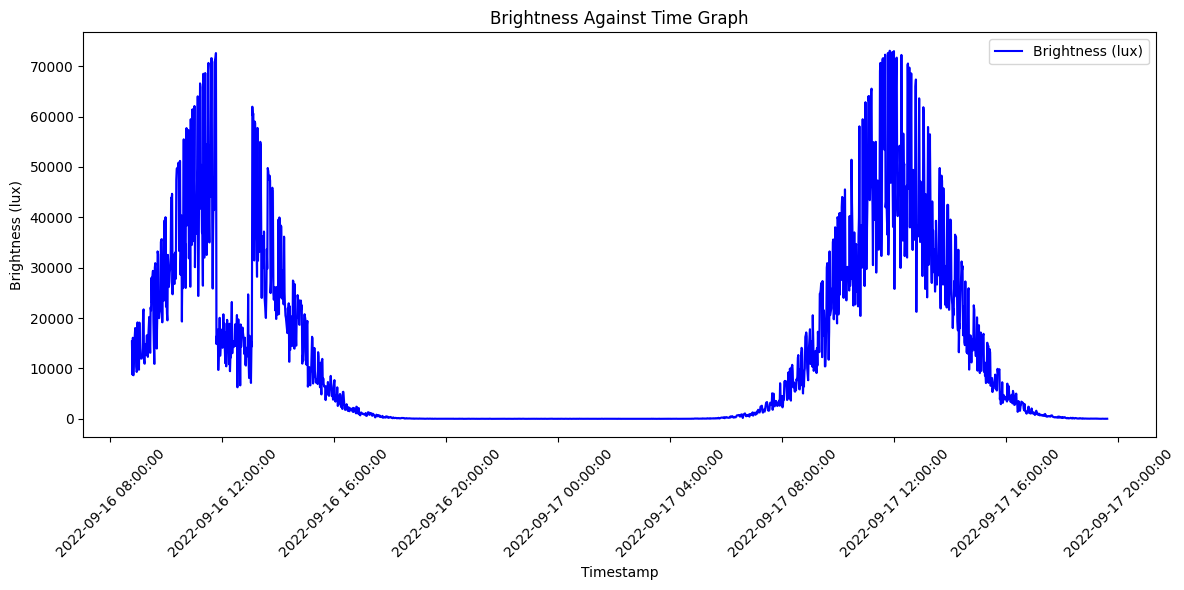

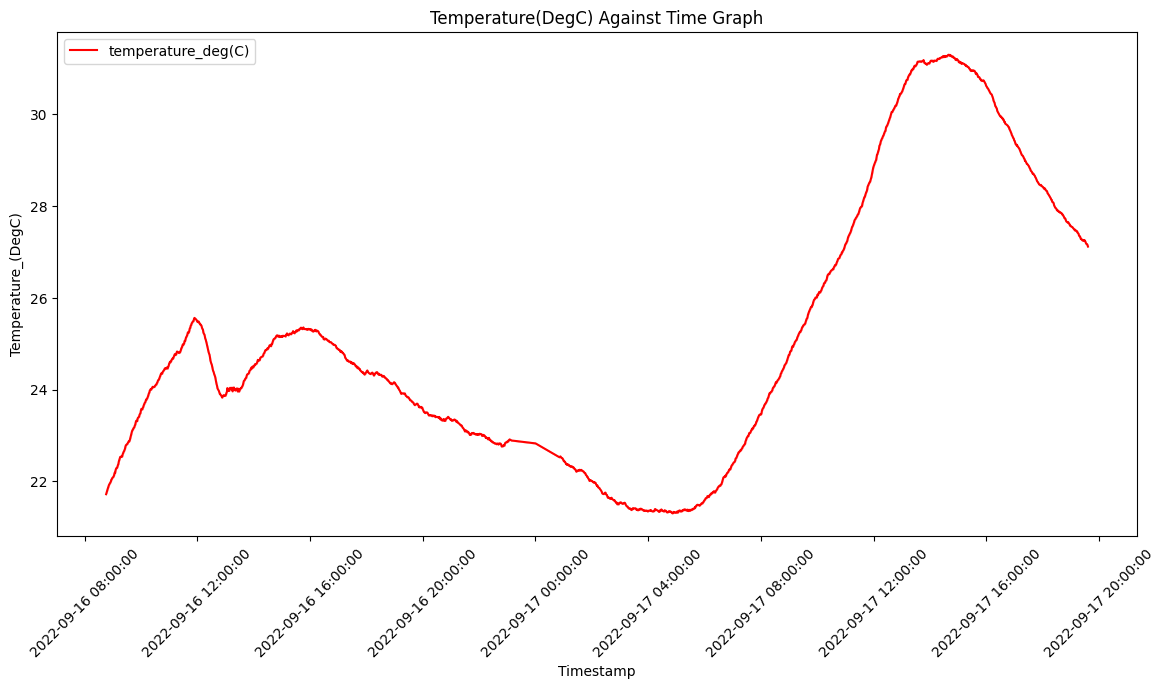

In [13]:
import seaborn as sns
import pandas as pd
import numpy as np #use the mean function to find the average of the temperature of the numpy 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
from datetime import datetime

def parse_timestamp(ts):
    try:
        # Requires Python 3.7 and above
        ts = datetime.fromisoformat(ts)
    except:
        pass
    return ts

# Sample that just imports from json and prints all the readings imports from the json file
#run_time = curr_time
with open(f'readings_{1728542940}_light.json', 'r') as f:
    light_readings = json.load(f)
with open(f'readings_{1728542940}_temp.json', 'r') as f:
    temp_readings = json.load(f)

#parse through and structure the data for light and temperature data
for light_reading in light_readings:
    light_reading['timestamp'] = parse_timestamp(light_reading['timestamp'])
    print('Timestamp:', end=' ')
    print(light_reading['timestamp'], end=' ')
    print('Brightness (lux):', end=' ')
    print(light_reading['brightness_lux'])

for temp_reading in temp_readings:
    temp_reading['timestamp'] = parse_timestamp(temp_reading['timestamp'])
    print('Timestamp:', end=' ')
    print(temp_reading['timestamp'], end=' ')
    print('Temperature (degC):', end=' ')
    print(temp_reading['temperature_degC'])

light_data = {
    'timestamp': [light_reading['timestamp'] for light_reading in light_readings],
    'brightness_lux': [light_reading['brightness_lux'] for light_reading in light_readings]
}

temp_data = {
    'timestamp': [temp_reading['timestamp'] for temp_reading in temp_readings],
    'temperature_degC': [temp_reading['temperature_degC'] for temp_reading in temp_readings]
}
#convert to pandas(dataframe for easier plotting)   
light_df = pd.DataFrame(light_data)
temp_df = pd.DataFrame(temp_data)




#Q2A
#plotting light vs time
plt.figure(figsize=(12, 6))
sns.lineplot(x='timestamp', y='brightness_lux', data=light_df, label='Brightness (lux)', color='blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.title('Brightness Against Time Graph')
plt.xlabel('Timestamp')
plt.ylabel('Brightness (lux)', color='black')
plt.xticks(rotation=45)  # Rotate timestamps for better readability
plt.tight_layout()  # Adjust layout to prevent label cut-off
plt.show()

#plotting temp vs time
plt.figure(figsize=(12, 6))
sns.lineplot(x='timestamp', y='temperature_degC', data=temp_df, label='temperature_deg(C)', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.title('Temperature(DegC) Against Time Graph')
plt.xlabel('Timestamp')
plt.ylabel('Temperature_(DegC)', color='black')
plt.tight_layout()  # Adjust layout to prevent label cut-off
plt.xticks(rotation=45)  # Rotate timestamps for better readability
plt.show()

#summarize the table and fill in the average sunrise and time 

<h2>Average Values and Sunrise and Sunset Table Calculation</h2>

In [15]:
from datetime import datetime, timedelta
#Calculate the average sunrise and sunset timings. convert to mins 
# Group by date to find the earliest (sunrise) and latest (sunset) timestamps each day
temp_df['date'] = temp_df['timestamp'].dt.date
daily_sunrise = temp_df.groupby('date')['timestamp'].min().dt.time
daily_sunset = temp_df.groupby('date')['timestamp'].max().dt.time

# Helper function to convert time to minutes since midnight
def time_to_minutes(t):
    return t.hour * 60 + t.minute

# Helper function to convert minutes back to time (HH:MM format)
def minutes_to_time(minutes):
    return (datetime.min + timedelta(minutes=minutes)).time()

# Calculate average sunrise and sunset times
average_sunrise_minutes = sum(time_to_minutes(t) for t in daily_sunrise) // len(daily_sunrise)
average_sunset_minutes = sum(time_to_minutes(t) for t in daily_sunset) // len(daily_sunset)

average_sunrise = minutes_to_time(average_sunrise_minutes)
average_sunset = minutes_to_time(average_sunset_minutes)

# Print the average sunrise and sunset times in HH:MM AM/PM format

avg_temp = temp_df['temperature_degC'].mean()
max_temp = temp_df['temperature_degC'].max()
min_temp = temp_df['temperature_degC'].min()

print("Average Sunrise Time:", average_sunrise.strftime("%I:%M %p"))
print("Average Sunset Time:", average_sunset.strftime("%I:%M %p"))
print(f"Average Temperature: {avg_temp:.2f}°C")
print(f"Max Temperature: {max_temp:.2f}°C")
print(f"Min Temperature: {min_temp:.2f}°C")


Average Sunrise Time: 04:23 AM
Average Sunset Time: 09:47 PM
Average Temperature: 25.03°C
Max Temperature: 31.30°C
Min Temperature: 21.30°C


<h3>
Q2B
Fitting the Machine learning Model
    1. Model 1: Random Forest
    2. Model 2: Decision Tree
    3. Model 3: SVM & Random Forest(Try both methods) - Compare prediction 
</h3>


C:\Users\power\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\power\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\power\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\power\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\power\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with f


Future Predictions:
                   timestamp  predicted_temperature_degC
0 2022-09-17 19:51:00.698771                    27.12559
1 2022-09-17 20:06:00.698771                    27.13241
2 2022-09-17 20:21:00.698771                    27.14363
3 2022-09-17 20:36:00.698771                    27.15997
4 2022-09-17 20:51:00.698771                    27.15121


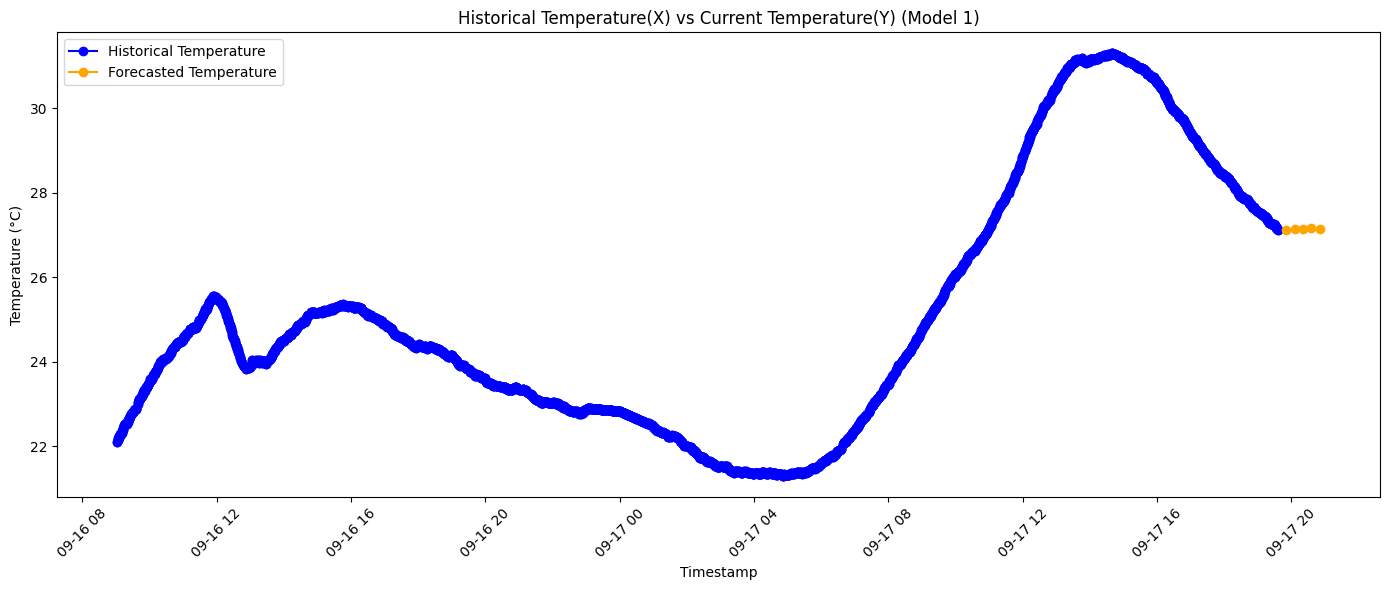

In [40]:
#Model 1: X is historical values of temperature; Y is current temperature - Random Forest 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
for lag in range(1, 4):  # Using the last 3 time steps as features
    temp_df[f'lag_{lag}'] = temp_df['temperature_degC'].shift(lag)

    # Drop rows with NaN values (due to lagging)
temp_df.dropna(inplace=True)

    # Define X and Y
X = temp_df[[f'lag_{lag}' for lag in range(1, 4)]] #create the historical values of (X)
Y = temp_df['temperature_degC']

 # Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Fit the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

    # Make predictions on the test set
Y_pred = model.predict(X_test)


    # Future predictions
last_observed = temp_df.iloc[-1]  # Get the last observed temperature
predictions = []

    # Forecast future temperatures
for _ in range(5):
        # Prepare the input data for the next prediction
        lagged_inputs = [last_observed[f'lag_{lag}'] for lag in range(1, 4)] #last observed 3 inputs 
        next_prediction = model.predict([lagged_inputs])[0]
        predictions.append(next_prediction)
  # Update the last observed values for the next iteration
        # Shift the lagged values
        last_observed = {
            'lag_1': next_prediction,
            'lag_2': last_observed['lag_1'],
            'lag_3': last_observed['lag_2'],
            'temperature_degC': next_prediction  # For demonstration, not used further
        }

    # Generate future timestamps
future_timestamps = [temp_df['timestamp'].iloc[-1] + timedelta(minutes=15 * (i + 1)) for i in range(5)] #5 additional forecasted readings
    
    # Create a DataFrame for future predictions
future_df = pd.DataFrame({'timestamp': future_timestamps, 'predicted_temperature_degC': predictions})

    # Print future predictions
print("\nFuture Predictions:")
print(future_df)

    # Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(temp_df['timestamp'], temp_df['temperature_degC'], label='Historical Temperature', color='blue', marker='o')
plt.plot(future_df['timestamp'], future_df['predicted_temperature_degC'], label='Forecasted Temperature', color='orange', marker='o')
plt.title('Historical Temperature(X) vs Current Temperature(Y) (Model 1)')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


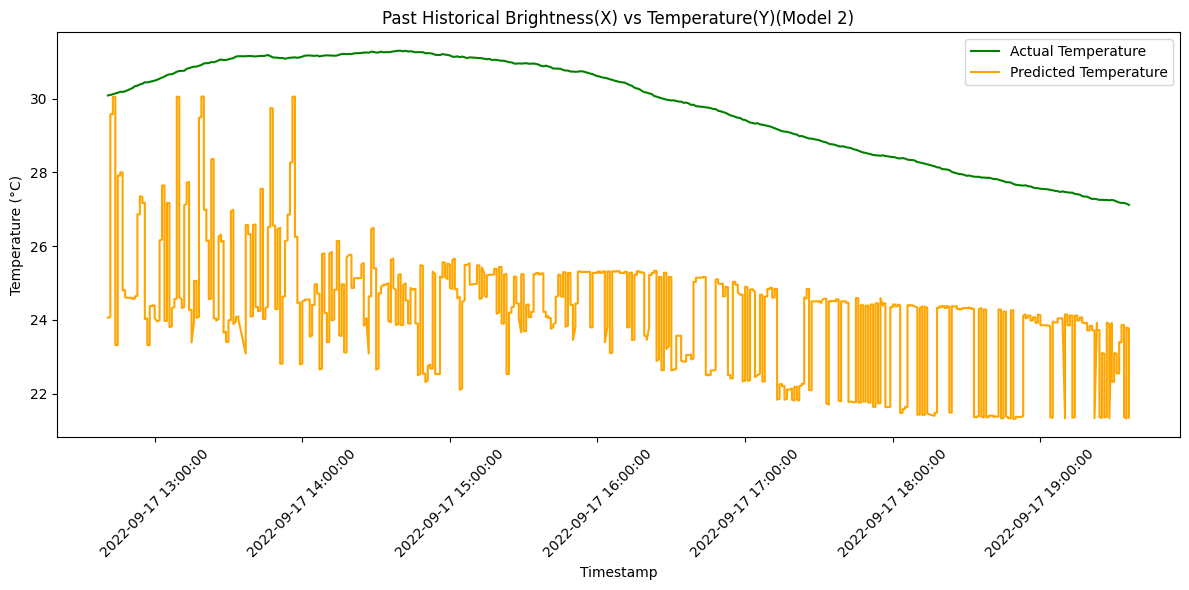

In [39]:
#Model 2: X is historical values of brightness; Y is current temperature #Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
# Step 1: Feature Engineering

#ensure the timestamp is in line with the date-time format
light_df['timestamp'] = pd.to_datetime(light_df['timestamp'])
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])

# Merge light and temperature data on timestamp by order
merged_df = pd.merge_asof(light_df.sort_values('timestamp'), 
                          temp_df.sort_values('timestamp'), 
                          on='timestamp')

# Drop any rows with missing values after merge
merged_df.dropna(inplace=True)

# Sort by timestamp
merged_df.sort_values('timestamp', inplace=True)


# Define number of lag hours
lag_hours = 5  # You can adjust this based on your data frequency and requirements


for lag in range(1, lag_hours + 1):
    merged_df[f'brightness_lag_{lag}'] = merged_df['brightness_lux'].shift(lag)

# Drop rows with NaN values resulting from lagging
merged_df.dropna(inplace=True)

#  Define Features and Target
feature_cols = [f'brightness_lag_{lag}' for lag in range(1, lag_hours + 1)]
X = merged_df[feature_cols]
y = merged_df['temperature_degC']

# Split Data into Training and Testing Sets
split_fraction = 0.8  # 80% for training, 20% for testing
split_index = int(len(merged_df) * split_fraction)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

#  Initialize and Train the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 5: Make Predictions on the Test Set
y_pred = model.predict(X_test)


# Step 7: Visualize Actual vs Predicted Temperatures
plt.figure(figsize=(12, 6))
plt.plot(merged_df['timestamp'].iloc[split_index:], y_test, label='Actual Temperature', color='green')
plt.plot(merged_df['timestamp'].iloc[split_index:], y_pred, label='Predicted Temperature', color='orange')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.title('Past Historical Brightness(X) vs Temperature(Y)(Model 2)')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# -------------------------------------------
# Making Predictions Beyond the Last Datapoint
# -------------------------------------------

# To predict beyond the last datapoint, we need to assume or obtain future brightness values.
# For illustration, we'll assume brightness remains constant at the last observed value.




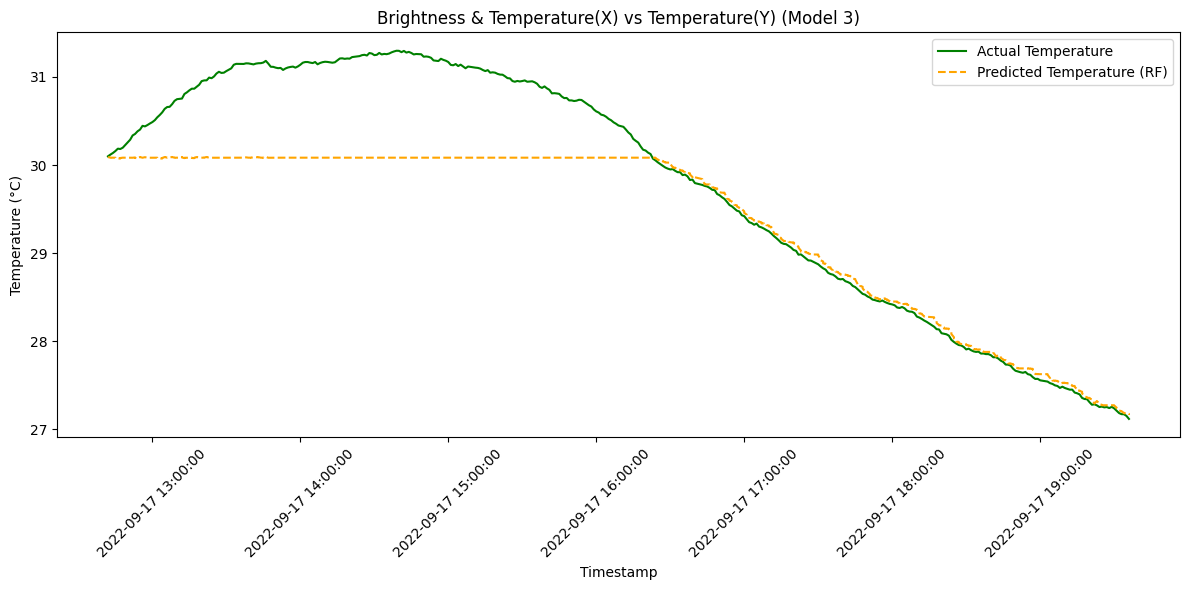


Future Temperature Predictions (Random Forest):
                   timestamp  predicted_temperature_degC
0 2022-09-17 20:36:00.698771                    26.90157
1 2022-09-17 21:36:00.698771                    25.90841
2 2022-09-17 22:36:00.698771                    23.37934
3 2022-09-17 23:36:00.698771                    23.12824
4 2022-09-18 00:36:00.698771                    22.87898


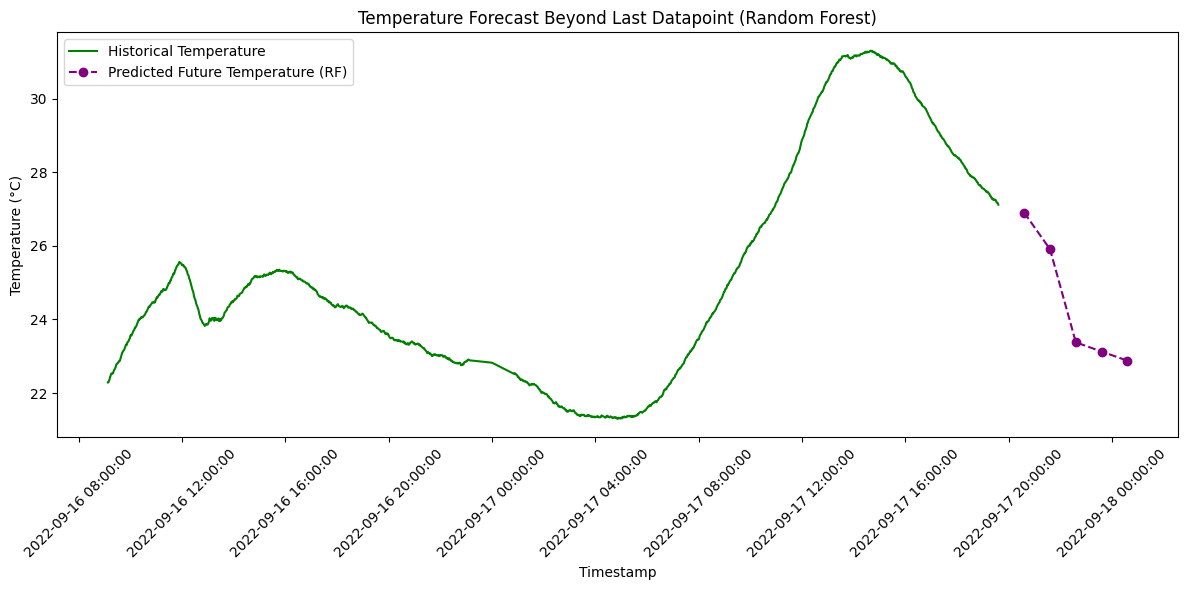

In [38]:
#Model 3: X is historica l values of brightness and temperature, Y is current temperature. #RandomForest
average_brightness = np.mean(merged_df['brightness_lux'])
average_temperature = np.mean(merged_df['temperature_degC'])

lag_periods = 3  # You can adjust this based on your data frequency and requirements

# Create lag features for brightness
for lag in range(1, lag_periods + 1):
    merged_df[f'brightness_lag_{lag}'] = merged_df['brightness_lux'].shift(lag)

# Create lag features for temperature
for lag in range(1, lag_periods + 1):
    merged_df[f'temperature_lag_{lag}'] = merged_df['temperature_degC'].shift(lag)

# Drop rows with NaN values resulting from lagging
merged_df.dropna(inplace=True)

# Step 2: Define Features and Target
# Features (X): All lagged brightness and temperature features
feature_cols = [f'brightness_lag_{lag}' for lag in range(1, lag_periods + 1)] + \
              [f'temperature_lag_{lag}' for lag in range(1, lag_periods + 1)]
X = merged_df[feature_cols]
y = merged_df['temperature_degC']

# Step 3: Split Data into Training and Testing Sets
# Since it's time series data, we'll split based on time to prevent data leakage
split_fraction = 0.8  # 80% for training, 20% for testing
split_index = int(len(merged_df) * split_fraction)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

# Step 4: Initialize and Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Make Predictions on the Test Set
y_pred_rf = rf_model.predict(X_test)

# Step 7: Visualize Actual vs Predicted Temperatures
plt.figure(figsize=(12, 6))
plt.plot(merged_df['timestamp'].iloc[split_index:], y_test, label='Actual Temperature', color='green')
plt.plot(merged_df['timestamp'].iloc[split_index:], y_pred_rf, label='Predicted Temperature (RF)', color='orange', linestyle='--')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.title('Brightness & Temperature(X) vs Temperature(Y) (Model 3)')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------------------
# Making Predictions Beyond the Last Datapoint
# -------------------------------------------

# Number of future predictions
future_steps = 5  # e.g., predict next 5 timestamps

# Function to generate future brightness and temperature values based on historical averages
def generate_future_features(last_timestamp, future_steps, merged_df, lag_periods):
    future_brightness = []
    future_temperature = []
    future_features = []
    
    # Assuming consistent time intervals; extract the interval from the last two timestamps
    if len(merged_df['timestamp']) >= 2:
        time_delta = merged_df['timestamp'].iloc[-1] - merged_df['timestamp'].iloc[-2]
        if time_delta <= timedelta(0):
            # Handle non-positive time_delta
            time_delta = timedelta(hours=1)
    else:
        time_delta = timedelta(hours=1)  # Default to 1 hour if not enough data
    
    # Initialize lag lists with the last known lagged values
    brightness_lags = merged_df[[f'brightness_lag_{lag}' for lag in range(1, lag_periods +1)]].iloc[-1].tolist()
    temperature_lags = merged_df[[f'temperature_lag_{lag}' for lag in range(1, lag_periods +1)]].iloc[-1].tolist()
    
    for step in range(1, future_steps + 1):
        future_time = last_timestamp + time_delta * step
        future_hour = future_time.hour
        
        # Generate future brightness based on historical average for the hour
        avg_brightness = merged_df[merged_df['timestamp'].dt.hour == future_hour]['brightness_lux'].mean()
        if np.isnan(avg_brightness):
            avg_brightness = average_brightness
        future_brightness.append(avg_brightness)
        
        # Generate future temperature based on historical average for the hour
        avg_temperature = merged_df[merged_df['timestamp'].dt.hour == future_hour]['temperature_degC'].mean()
        if np.isnan(avg_temperature):
            avg_temperature = average_temperature
        future_temperature.append(avg_temperature)
        
        # Update lag lists
        brightness_lags.append(avg_brightness)
        brightness_lags.pop(0)
        
        temperature_lags.append(avg_temperature)
        temperature_lags.pop(0)
        
        # Combine brightness and temperature lags
        combined_features = brightness_lags + temperature_lags
        future_features.append(combined_features.copy())
    
    return future_features, [last_timestamp + time_delta * (i + 1) for i in range(future_steps)]

# Generate future features
future_features, future_timestamps = generate_future_features(merged_df['timestamp'].iloc[-1], 
                                                               future_steps, 
                                                               merged_df, 
                                                               lag_periods)

# Convert future features to DataFrame
future_X_rf = pd.DataFrame(future_features, columns=feature_cols)

# Predict future temperatures using Random Forest model
future_predictions_rf = rf_model.predict(future_X_rf)

# Create a DataFrame for future predictions
future_df_rf = pd.DataFrame({
    'timestamp': future_timestamps,
    'predicted_temperature_degC': future_predictions_rf
})

print("\nFuture Temperature Predictions (Random Forest):")
print(future_df_rf)

# Visualize Future Predictions
plt.figure(figsize=(12, 6))
# Plot existing temperature data
plt.plot(merged_df['timestamp'], merged_df['temperature_degC'], label='Historical Temperature', color='green')
# Plot future predictions
plt.plot(future_df_rf['timestamp'], future_df_rf['predicted_temperature_degC'], label='Predicted Future Temperature (RF)', color='purple', marker='o', linestyle='--')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.title('Temperature Forecast Beyond Last Datapoint (Random Forest)')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()